# Обучение определения фейковых фактов о COVID и вакцинации

In [1]:
import math

import torch
import pandas as pd
import numpy as np

In [2]:
DEVICE = 'cpu'
if torch.backends.mps.is_available():
    DEVICE = 'mps'
if torch.cuda.is_available():
    DEVICE = 'cuda'

In [3]:
from pathlib import Path

DATA_PATH = Path('data/')
DATA_PATH.mkdir(parents=True, exist_ok=True)

DATA_CACHE = Path('data/cache_dir/')
DATA_CACHE.mkdir(parents=True, exist_ok=True)

DATA_PATH_SAVE_MODELS = Path('data/models/')
DATA_PATH_SAVE_MODELS.mkdir(parents=True, exist_ok=True)

DATA_SYNTHETIC = Path('synthetic/')
DATA_SYNTHETIC.mkdir(parents=True, exist_ok=True)

pd.set_option('display.max_colwidth', 500) 

In [4]:
MODEL_NAME = "roberta-base"
TRAIN_DF_NAME = "covid_vaccine_fake_clear.xlsx"
MAX_LENGTH = 128
BATCH_SIZE = 128

# Датасет

In [5]:
data_df = pd.read_excel(DATA_PATH / TRAIN_DF_NAME)
data_df.head(1)

,text,is_fake,original_label_1,source,original_label_2
0,The CDC currently reports 99031 deaths. In general the discrepancies in death counts between different sources are small and explicable. The death toll stands at roughly 100000 people today.,0,real,nanyy1025,NaN


In [6]:
data_df.rename(columns={'is_fake': 'label'}, inplace=True)
data_df = data_df.fillna("")

for col in data_df.select_dtypes(include=["object", "bool"]).columns:
    data_df[col] = data_df[col].astype(str)

In [7]:
# label_id2idx = {int(key): int(idx) for idx, key in enumerate(data_df['label_id'].unique())}

# idx2label_id = dict([(v, k) for k, v in label_id2idx.items()])

# idx2label = {k: df_messages[df_messages['label_id'] == v]['label'].iloc[0] for k, v in idx2label_id.items()}

# label2idx = dict([(v, k) for k, v in idx2label.items()])

# df_messages['label_idx'] = df_messages['label_id'].apply(lambda x: label_id2idx[x])

# df_messages.head(1)


idx2label = {
    0: "Real",
    1: "Fake"
}

In [8]:
NUM_CLASSES = len(idx2label)
NUM_CLASSES

2

In [9]:
from sklearn.model_selection import train_test_split

train_val_df, test_df = train_test_split(data_df, test_size=0.1, stratify=data_df["label"], random_state=42, shuffle=True)
train_df, val_df = train_test_split(train_val_df, test_size=0.1, stratify=train_val_df["label"], random_state=42, shuffle=True)

print(f"Размер тренировочного набора: {len(train_df)}")
print(f"Размер валидационного набора: {len(val_df)}")
print(f"Размер тестового набора: {len(test_df)}")

Размер тренировочного набора: 13179
Размер валидационного набора: 1465
Размер тестового набора: 1628


In [10]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import PreTrainedTokenizer
import pandas as pd
from typing import Dict, Tuple


class TokenizedDataset(Dataset):
    def __init__(
        self, 
        dataframe: pd.DataFrame, 
        tokenizer: PreTrainedTokenizer, 
        max_length: int, 
        tensor_dtype: Tuple[torch.dtype, torch.dtype, torch.dtype] = (torch.long, torch.long, torch.long)
    ):
        """
        Инициализация датасета с токенизацией.

        Args:
            dataframe (pd.DataFrame): DataFrame с колонками "text" и "label".
            tokenizer (PreTrainedTokenizer): Токенайзер для преобразования текста.
            max_length (int): Максимальная длина токенов.
            tensor_dtype (tuple): Типы данных для токенов и меток.
        """
        self.tensor_dtype = tensor_dtype

        # Токенизация данных
        tokenized_data = tokenizer(
            dataframe["text"].tolist(),
            max_length=max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )

        self.input_ids = tokenized_data["input_ids"].to(dtype=self.tensor_dtype[0])
        self.attention_mask = tokenized_data["attention_mask"].to(dtype=self.tensor_dtype[1])
        self.labels = torch.tensor(dataframe["label"].tolist(), dtype=self.tensor_dtype[2])

    def __len__(self) -> int:
        """
        Возвращает количество примеров в датасете.
        """
        return len(self.labels)

    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        """
        Возвращает токенизированные данные и метки.

        Args:
            idx (int): Индекс примера.

        Returns:
            Dict[str, torch.Tensor]: Словарь с токенами и меткой.
        """
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_mask[idx],
            "labels": self.labels[idx],
        }


In [11]:
from torch.utils.data import DataLoader
from transformers import PreTrainedTokenizer
import pandas as pd


def create_dataloader(
    dataframe: pd.DataFrame,
    tokenizer: PreTrainedTokenizer,
    max_length: int = 64,
    batch_size: int = 16,
    shuffle: bool = True,
    tensor_dtype=(torch.long, torch.long, torch.long),
) -> DataLoader:
    """
    Создание DataLoader из DataFrame.

    Args:
        dataframe (pd.DataFrame): DataFrame с колонками "text" и "label".
        tokenizer (PreTrainedTokenizer): Токенайзер для преобразования текста.
        max_length (int): Максимальная длина токенов.
        batch_size (int): Размер батча.
        shuffle (bool): Перемешивать ли данные.
        tensor_dtype (tuple): Типы данных для токенов и меток.

    Returns:
        DataLoader: DataLoader для работы с моделью.
    """
    dataset = TokenizedDataset(dataframe, tokenizer, max_length, tensor_dtype=tensor_dtype)
    dataloader = DataLoader(
        dataset, 
        batch_size=batch_size, 
        shuffle=shuffle, 
    )
    return dataloader


In [12]:
from transformers import RobertaTokenizer

tokenizer: RobertaTokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME, cache_dir=DATA_CACHE)

train_loader = create_dataloader(
    dataframe=train_df,
    tokenizer=tokenizer,
    max_length=MAX_LENGTH,
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_loader = create_dataloader(
    dataframe=val_df,
    tokenizer=tokenizer,
    max_length=MAX_LENGTH,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_loader = create_dataloader(
    dataframe=test_df,
    tokenizer=tokenizer,
    max_length=MAX_LENGTH,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Выводим размер набора данных
print(f"Размер тренировочного набора: {len(train_loader.dataset)}")
print(f"Размер валидационного набора: {len(val_loader.dataset)}")
print(f"Размер тестового набора: {len(test_loader.dataset)}")


Размер тренировочного набора: 13179
Размер валидационного набора: 1465
Размер тестового набора: 1628


# Модель

In [13]:
from typing import Tuple, Dict, Any

import torch
from torch.utils.data import DataLoader
from torch.optim import Optimizer
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, f1_score


class VaccineFakeClassifierTrainer:
    def __init__(
        self,
        model: torch.nn.Module,
        train_loader: DataLoader,
        val_loader: DataLoader,
        optimizer: Optimizer,
        criterion: torch.nn.Module,
        device: torch.device,
    ):
        """
        Инициализация класса Trainer.

        Args:
            model: Модель для обучения (e.g., RobertaForSequenceClassification).
            train_loader: DataLoader для обучающего набора.
            val_loader: DataLoader для валидационного набора.
            optimizer: Оптимизатор.
            criterion: Функция потерь.
            device: Устройство ('cuda' или 'cpu').
        """
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device
        self.history = {
            "train_loss": [],
            "val_loss": [],
            "train_metrics": [],
            "val_metrics": []
        }

        self.model.to(self.device)

    def train_epoch(self) -> Tuple[float, Dict[str, float]]:
        """
        Обучение модели за одну эпоху.

        Returns:
            Средние потери и метрики за эпоху.
        """
        self.model.train()
        running_loss = 0.0
        all_labels = []
        all_preds = []

        for batch in tqdm(self.train_loader, desc="Training"):
            input_ids = batch["input_ids"].to(self.device)
            attention_mask = batch["attention_mask"].to(self.device)
            labels = batch["labels"].to(self.device)

            self.optimizer.zero_grad()

            outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            running_loss += loss.item()

            loss.backward()
            self.optimizer.step()

            preds = logits.argmax(dim=-1)
            all_labels.append(labels.cpu())
            all_preds.append(preds.cpu())

        all_labels = torch.cat(all_labels)
        all_preds = torch.cat(all_preds)
        metrics = self._compute_metrics(all_preds, all_labels)

        epoch_loss = running_loss / len(self.train_loader)
        return epoch_loss, metrics

    def validate_epoch(self) -> Tuple[float, Dict[str, float]]:
        """
        Валидация модели за одну эпоху.

        Returns:
            Средние потери и метрики за эпоху.
        """
        self.model.eval()
        running_loss = 0.0
        all_labels = []
        all_preds = []

        with torch.no_grad():
            for batch in tqdm(self.val_loader, desc="Validation"):
                input_ids = batch["input_ids"].to(self.device)
                attention_mask = batch["attention_mask"].to(self.device)
                labels = batch["labels"].to(self.device)

                outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                logits = outputs.logits

                running_loss += loss.item()

                preds = logits.argmax(dim=-1)
                all_labels.append(labels.cpu())
                all_preds.append(preds.cpu())

        all_labels = torch.cat(all_labels)
        all_preds = torch.cat(all_preds)
        metrics = self._compute_metrics(all_preds, all_labels)

        epoch_loss = running_loss / len(self.val_loader)
        return epoch_loss, metrics

    def fit(self, num_epochs: int):
        """
        Обучение и валидация модели.

        Args:
            num_epochs: Общее количество эпох.
        """
        for epoch in range(num_epochs):
            print(f"\nEpoch {epoch + 1}/{num_epochs}")

            train_loss, train_metrics = self.train_epoch()
            val_loss, val_metrics = self.validate_epoch()

            self.history["train_loss"].append(train_loss)
            self.history["val_loss"].append(val_loss)
            self.history["train_metrics"].append(train_metrics)
            self.history["val_metrics"].append(val_metrics)

            print(f"Train Loss: {train_loss:.4f} | Validation Loss: {val_loss:.4f}")
            print(f"Train Metrics: {train_metrics} | Validation Metrics: {val_metrics}")

    def plot_results(self, metrics_to_plot=None):
        """
        Построение графиков потерь и метрик для обучения и валидации.

        Args:
            metrics_to_plot: Список метрик для визуализации.
        """
        if metrics_to_plot is None:
            metrics_to_plot = ["accuracy", "f1"]

        num_plots = len(metrics_to_plot) + 1
        plt.figure(figsize=(15, 5 * (num_plots // 2 + 1)))

        # График потерь
        plt.subplot((num_plots + 1) // 2, 2, 1)
        plt.plot(self.history["train_loss"], label="Train Loss", color="blue", linestyle="--")
        plt.plot(self.history["val_loss"], label="Validation Loss", color="red", linestyle="-")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Loss over Epochs")
        plt.legend()
        plt.grid(True)

        # Графики метрик
        for i, metric in enumerate(metrics_to_plot, start=2):
            train_metric = [m[metric] for m in self.history["train_metrics"]]
            val_metric = [m[metric] for m in self.history["val_metrics"]]

            plt.subplot((num_plots + 1) // 2, 2, i)
            plt.plot(train_metric, label=f"Train {metric.capitalize()}", color="blue", linestyle="--")
            plt.plot(val_metric, label=f"Validation {metric.capitalize()}", color="red", linestyle="-")
            plt.xlabel("Epochs")
            plt.ylabel(metric.capitalize())
            plt.title(f"{metric.capitalize()} over Epochs")
            plt.legend()
            plt.grid(True)

        plt.tight_layout()
        plt.show()

    @staticmethod
    def _compute_metrics(preds: torch.Tensor, labels: torch.Tensor) -> Dict[str, float]:
        """
        Вычисление метрик.

        Args:
            preds: Предсказания модели.
            labels: Истинные метки.

        Returns:
            Словарь метрик.
        """
        preds = preds.numpy()
        labels = labels.numpy()

        metrics = {
            "accuracy": accuracy_score(labels, preds),
            "f1": f1_score(labels, preds, average="weighted"),
        }
        return metrics


# Обучение

In [14]:
import torch
from torch.optim import AdamW
from transformers import RobertaForSequenceClassification

LEARNING_RATE = 1e-5
NUM_EPOCHS = 5
WEIGHT_DECAY = 0.01

model = RobertaForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=NUM_CLASSES, cache_dir=DATA_CACHE)

model.to(DEVICE)

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

criterion = torch.nn.CrossEntropyLoss()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
trainer = VaccineFakeClassifierTrainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=DEVICE,
)

In [16]:
trainer.fit(num_epochs=NUM_EPOCHS)


Epoch 1/5


Training:   0%|          | 0/103 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.3617 | Validation Loss: 0.1999
Train Metrics: {'accuracy': 0.8326883678579559, 'f1': 0.8268881960547019} | Validation Metrics: {'accuracy': 0.9180887372013652, 'f1': 0.9180887372013652}

Epoch 2/5


Training:   0%|          | 0/103 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.1781 | Validation Loss: 0.1674
Train Metrics: {'accuracy': 0.9335306168905076, 'f1': 0.9332290067054612} | Validation Metrics: {'accuracy': 0.936518771331058, 'f1': 0.9365103073675903}

Epoch 3/5


Training:   0%|          | 0/103 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.1320 | Validation Loss: 0.1755
Train Metrics: {'accuracy': 0.9525760679869489, 'f1': 0.952429343407871} | Validation Metrics: {'accuracy': 0.9351535836177475, 'f1': 0.9353051742539662}

Epoch 4/5


Training:   0%|          | 0/103 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.1019 | Validation Loss: 0.1653
Train Metrics: {'accuracy': 0.9630472721754306, 'f1': 0.9629800988001377} | Validation Metrics: {'accuracy': 0.941296928327645, 'f1': 0.9410734388962569}

Epoch 5/5


Training:   0%|          | 0/103 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.0776 | Validation Loss: 0.1798
Train Metrics: {'accuracy': 0.9710144927536232, 'f1': 0.9709688443643939} | Validation Metrics: {'accuracy': 0.936518771331058, 'f1': 0.9366526530882011}


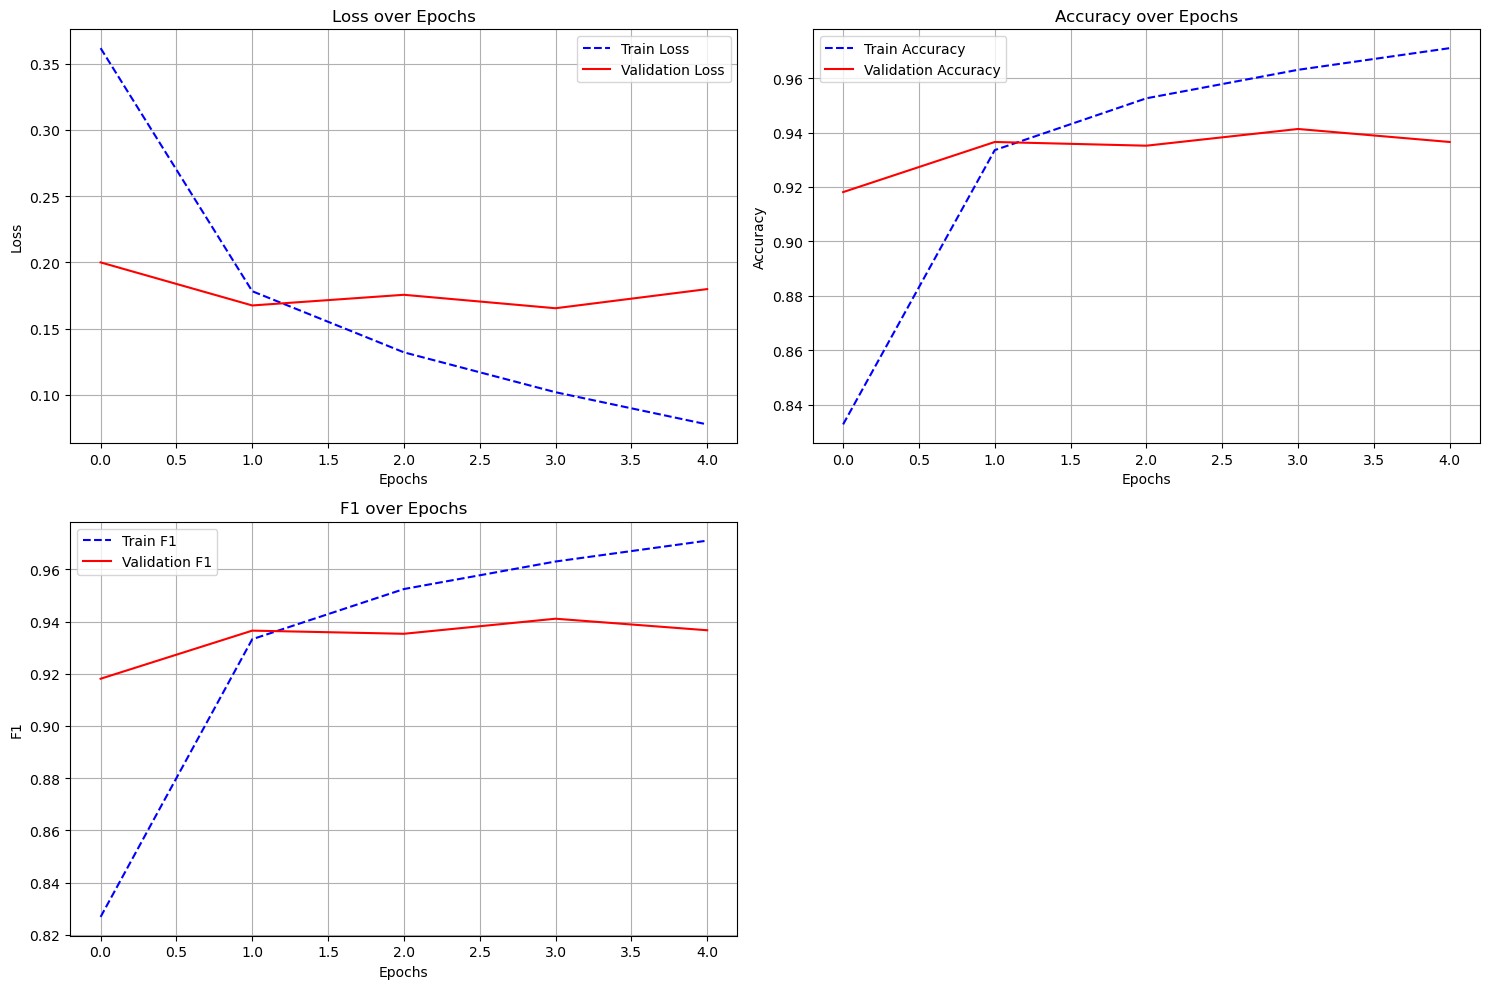

In [17]:
trainer.plot_results()

In [18]:
model_save_path = DATA_PATH_SAVE_MODELS / "covid_vaccine_fake_model"
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)
print(f"Модель и токинайзер сохранены в: {model_save_path}")

Модель и токинайзер сохранены в: data\models\covid_vaccine_fake_model


# Тестирование

In [19]:
import torch
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score


def test_model(
    model: torch.nn.Module,
    test_loader: DataLoader,
    test_df: pd.DataFrame,
    idx2label: dict,
    device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
) -> pd.DataFrame:
    """
    Тестирует модель на тестовом DataLoader и возвращает DataFrame с результатами.

    Args:
        model (torch.nn.Module): Обученная модель.
        test_loader (DataLoader): DataLoader для тестового набора.
        test_df (pd.DataFrame): Исходный DataFrame тестовых данных.
        idx2label (dict): Словарь, отображающий индексы категорий в названия.
        device (torch.device): Устройство для вычислений (CPU/GPU).

    Returns:
        pd.DataFrame: DataFrame с результатами, содержащий:
            - 'text': текст примера,
            - 'true_label': истинная метка,
            - 'predicted_label': предсказанная метка,
            - 'probability': вероятность предсказания,
            - 'correct': корректность предсказания (True/False).
    """
    model.eval()
    model.to(device)

    test_results = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            true_labels = batch["labels"].to(device)

            logits = model(input_ids=input_ids, attention_mask=attention_mask).logits
            probabilities = torch.softmax(logits, dim=-1).cpu().numpy()

            predictions = torch.argmax(logits, dim=-1).cpu().numpy()
            true_labels = true_labels.cpu().numpy()

            for true_label, predicted_label, probs in zip(true_labels, predictions, probabilities):
                test_results.append({
                    "true_label": idx2label[true_label],
                    "predicted_label": idx2label[predicted_label],
                    "probability": probs.tolist(),
                    "correct": true_label == predicted_label,
                })

    test_results_df = pd.DataFrame(test_results)

    test_df = test_df.reset_index(drop=True)
    test_df = pd.concat([test_df, test_results_df], axis=1)

    accuracy = accuracy_score(test_df["true_label"], test_df["predicted_label"])
    f1 = f1_score(test_df["true_label"], test_df["predicted_label"], average="weighted")

    print("\n=== Результаты тестирования ===")
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"F1 Score: {f1:.4f}")

    return test_df


In [20]:
test_results_df = test_model(
    model=model,
    test_loader=test_loader,
    test_df=test_df,
    idx2label=idx2label,
    device=DEVICE,
)

Testing:   0%|          | 0/13 [00:00<?, ?it/s]


=== Результаты тестирования ===
Accuracy: 93.43%
F1 Score: 0.9343


In [21]:
test_results_df.sample(10)

,text,label,original_label_1,source,original_label_2,true_label,predicted_label,probability,correct
267,Right now our model shows that: 📉5 states have reduced risk in re-opening 19 have moderate risk in re-opening 📈26 have elevated risk in re-opening. Find out more about your state and county at,0,real,nanyy1025,,Real,Real,"[0.9995456337928772, 0.0004543625400401652]",True
1335,10 Italian doctors have died due to \nThey died trying to save people's lives and in return sacrificed theirs.\nMy condolences to their Families.,1,fake,nanyy1025,,Fake,Fake,"[0.0010239009279757738, 0.9989761114120483]",True
304,If you are 65 or older you are at higher risk for getting seriously ill from Learn how you can take steps to protect yourself and slow the spread at,0,real,nanyy1025,,Real,Real,"[0.9990811347961426, 0.0009188728290610015]",True
152,Says professional soccer player Christian Eriksen received the Pfizer vaccine days before he collapsed during a game.,1,false,justinqbui_2,false,Fake,Fake,"[0.005575251765549183, 0.9944247007369995]",True
1598,Kabataan Representative in the Philippines Sarah Elago tested positive for coronavirus.,1,fake,nanyy1025,,Fake,Fake,"[0.017565902322530746, 0.982434093952179]",True
812,A video has been viewed hundreds of thousands of times in multiple Facebook posts which claim it shows two Italian doctors who contracted novel coronavirus which causes the disease COVID-19 while treating patients.,1,fake,nanyy1025,,Fake,Fake,"[0.001467701862566173, 0.9985322952270508]",True
1159,Obama Calls Trump’s Coronavirus Response A Chaotic Disaster,1,fake,nanyy1025,,Fake,Fake,"[0.004493189975619316, 0.995506763458252]",True
1430,Ghana’s leading biomedical research institute Noguchi approves COA FS a Ghana-made food nutritional supplement to fight the coronavirus.,1,fake,nanyy1025,,Fake,Fake,"[0.13134971261024475, 0.8686503171920776]",True
726,Superstar Rajinikanth has apologised to the public for travelling without an e-pass during the Covid-19 lockdown in Tamil Nadu.,1,False,justinqbui_1,,Fake,Fake,"[0.0038539173547178507, 0.9961460828781128]",True
1273,"“Man visited Albany, N.Y. days before dying from coronavirus.”",1,false,justinqbui_2,false,Fake,Fake,"[0.04993511736392975, 0.9500648379325867]",True


In [22]:
from transformers import PreTrainedTokenizer, PreTrainedModel
import torch


def test_model_with_text(
    model: PreTrainedModel,
    tokenizer: PreTrainedTokenizer,
    text: str,
    max_length: int = 128,
    label_map: dict = None,
):
    """
    Проверяет модель на введенном вручную тексте, используя argmax для классификации.

    Args:
        model (PreTrainedModel): Загруженная обученная модель (например, RobertaForSequenceClassification).
        tokenizer (PreTrainedTokenizer): Токенизатор для подготовки текста.
        text (str): Текст для классификации.
        max_length (int): Максимальная длина токенизированного текста.
        label_map (dict): Словарь для отображения меток, если метки числовые.

    Returns:
        dict: Словарь с текстом, вероятностями и предсказанными метками.
    """

    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    inputs = tokenizer(
        text,
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=-1).cpu().numpy()[0]  # Вероятности для каждого класса

    predicted_index = torch.argmax(logits, dim=-1).item()
    predicted_label = label_map[predicted_index] if label_map else predicted_index

    # Результаты
    result = {
        "text": text,
        "probabilities": probs.tolist(),
        "predicted_label": predicted_label
    }

    return result

Real

In [23]:
text = "COVID-19 vaccines do not affect fertility or reproductive health. This has been confirmed through multiple studies and ongoing research."

result = test_model_with_text(
    model=model,
    tokenizer=tokenizer,
    text=text,
    max_length=128,
    label_map=idx2label
)

print(result)

{'text': 'COVID-19 vaccines do not affect fertility or reproductive health. This has been confirmed through multiple studies and ongoing research.', 'probabilities': [0.9964038133621216, 0.0035962604451924562], 'predicted_label': 'Real'}


Fake

In [24]:
text = "COVID-19 vaccines affect fertility or reproductive health."

result = test_model_with_text(
    model=model,
    tokenizer=tokenizer,
    text=text,
    max_length=128,
    label_map=idx2label
)

print(result)

{'text': 'COVID-19 vaccines affect fertility or reproductive health.', 'probabilities': [0.3103806674480438, 0.6896193027496338], 'predicted_label': 'Fake'}
